# Read handwritten digits

In [107]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as opencv
from keras.utils.np_utils import to_categorical

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [109]:
print(train.iloc[:, 100:200].head(20))

    pixel99  pixel100  pixel101  pixel102  pixel103  pixel104  pixel105  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   
5         0         0         0         0         0         0         0   
6         0         0         0         0         0         0         0   
7         0         0         0         0         0         0         0   
8         0         0         0         0         0         0         0   
9         0         0         0         0         0         0         0   
10        0         0         0         0         0         0         0   
11        0         0         0         0         0         0         0   
12        0         0    

In [110]:
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = test.iloc[:, 0:]
y_train = to_categorical(y_train)
print(y_train)
print(np.shape(y_train))
print(np.shape(x_train))
print(np.shape(x_test))
print(type(x_train))

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(42000, 10)
(42000, 784)
(28000, 784)
<class 'pandas.core.frame.DataFrame'>


# Resizing Image Data

In [111]:
x_train = x_train / 255
x_test = x_test / 255

print(x_train.iloc[:, 100:200].head(10))

x_train_np = np.reshape(x_train.values, newshape=(x_train.shape[0], 28, 28, 1))
x_test_np = np.reshape(x_test.values, newshape=(x_test.shape[0], 28, 28, 1))

print(x_train_np.shape)
print(x_train_np[0, :])

   pixel100  pixel101  pixel102  pixel103  pixel104  pixel105  pixel106  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
5       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
6       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
7       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
8       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
9       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   pixel107  pixel108  pixel109    ...     pixel190  pixel191  pixel192  \
0       0.0       0.0       0.0    ...     0.039216       0.0       0.0   
1       0.0       0.0   

## Creation of training and validation set

In [112]:
num_of_digits = np.shape(x_train_np)[0]
x_valid = x_train_np[int(num_of_digits * 0.9): ]
y_valid = y_train[int(num_of_digits * 0.9): ]

x_train_np = x_train_np[:int(num_of_digits * 0.9)]
y_train = y_train[:int(num_of_digits * 0.9)]

print(np.shape(y_train))
print(np.shape(x_train_np))
print(np.shape(y_valid))
print(np.shape(x_valid))

(37800, 10)
(37800, 28, 28, 1)
(4200, 10)
(4200, 28, 28, 1)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


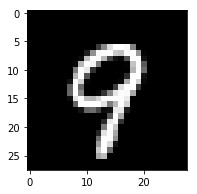

In [113]:
from matplotlib import pyplot as plt
import cv2 as opencv

img = x_valid[5]
img = opencv.resize(img, None, fx=1, fy=1, interpolation=opencv.INTER_CUBIC)

fig = plt.figure(figsize=(10, 10))
img_plot = fig.add_subplot(3, 3, 1)
img_plot.imshow(img, cmap='gray')

print(y_valid[5])

In [114]:
from keras.models import Sequential # Create feed-forword multilayer perceptron
from keras.optimizers import Adamax # Optimization technique, adam uses momentum to converge
from keras.layers import Convolution2D, BatchNormalization, Dropout, Dense, Flatten, MaxPool2D, Activation # Essential functions
from keras.layers.advanced_activations import LeakyReLU # Activation function
from keras.layers import Conv2D # convolution layer
from keras.callbacks import CSVLogger # callback function to log progress information
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau # callback functions to save progress
from keras.losses import categorical_crossentropy # loss function
from keras.preprocessing.image import ImageDataGenerator # data augmentation
from keras import optimizers

# Generate and augment synthetic data to improve robustness 

In [62]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    shear_range=10,
    zoom_range=0.2
)

datagen.fit(x_train_np)

## Callback functions

In [119]:
filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
# storage = shelve.open('saved_data')
csv_logger = CSVLogger('log.csv', append=True, separator=';')

callback_list = [checkpoint, learning_rate_reduction, csv_logger]

In [124]:
import tensorflow as tf 

def create_model():
    model = Sequential()
    
    model.add(Conv2D(64, 3, activation='relu', strides=1, use_bias=True, input_shape=(28, 28, 1)))
    model.add(Conv2D(64, 3, activation='relu', strides=1, use_bias=True))
    model.add(MaxPool2D())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, 3, activation='relu', strides=1, use_bias=True))
    model.add(Conv2D(32, 3, activation='relu', strides=1, use_bias=True))
    model.add(MaxPool2D())
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='linear'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='linear'))
    model.add(Dropout(0.3))
    
    model.add(Dense(10, activation='sigmoid'))
#     model.add(Activation(tf.nn.softmax))

    return model


model = create_model()

In [125]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 32)          0         
__________

# Build Model

In [126]:
adm = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['acc'])

model.fit(x_train_np, y_train, batch_size=60,
                    epochs=5, shuffle=True,
                    callbacks=callback_list,
                    validation_data=(x_valid, y_valid))

Train on 37800 samples, validate on 4200 samples
Epoch 1/5
37800/37800 [==============================] - 415s 11ms/step - loss: 0.2765 - acc: 0.9187 - val_loss: 0.0560 - val_acc: 0.9821

Epoch 00001: val_acc improved from -inf to 0.98214, saving model to best_model.hdf5
Epoch 2/5
  600/37800 [..............................] - ETA: 6:51 - loss: 0.1208 - acc: 0.9683

KeyboardInterrupt: 

In [127]:
from keras.models import load_model
model = load_model('best_model.hdf5')
model.fit(x_train_np, y_train, batch_size=60,
                    epochs=5, shuffle=True,
                    callbacks=callback_list,
                    validation_data=(x_valid, y_valid))

Train on 37800 samples, validate on 4200 samples
Epoch 1/5
 2940/37800 [=>............................] - ETA: 6:06 - loss: 0.1096 - acc: 0.9667

KeyboardInterrupt: 